## Visualise the training accuracy curve

In [6]:
import unidecode
import sys
sys.path.append("../wiktionary")
from categorise import categorise
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import enchant
from tqdm import tqdm_notebook 

#### Step 1: create functionality to load the training data.

In [27]:
d = enchant.Dict("en_US")
SUBSET_VOWELS = True

def load_train(seed, s_subset):
    print(f"Loading data for model with seed {seed}.")
    accuracies = defaultdict(list)
    for epoch in range(1, 25):
        with open("../wiktionary/wiktionary_train.src", encoding="utf-8") as f_src, \
             open("../wiktionary/wiktionary_train.tgt", encoding="utf-8") as f_tgt, \
             open(f"../opennmt/models/seed={seed}_wiktionary/wiktionary/lstms2s_train_pred_{epoch}.txt", encoding="utf-8") as f_prd:
            epoch_accuracies = defaultdict(list)
            for src, tgt, prd in zip(f_src, f_tgt, f_prd):
                category_tgt = categorise(src.strip(), tgt.strip())
                
                if category_tgt == 4 and src in s_subset:
                    epoch_accuracies[7].append(prd.strip() == tgt.strip())
                else:
                    epoch_accuracies[category_tgt].append(prd.strip() == tgt.strip())
            for suffix in epoch_accuracies:
                accuracies[suffix].append(np.mean(epoch_accuracies[suffix]))
    return accuracies

#### Step 2: create functionality to determine if the last character belongs to a vowel.

In [17]:
def s_belongs_to_subset(word, vowel=False):
    if not vowel:
        word = word.strip()
        if '<' in word: word = word[3:]
        word = word.replace(" ","").replace("</s>", "").strip()
        return d.check(word)
    word = word.strip().replace("</s>", "").strip()
    word = unidecode.unidecode(word)
    word = word.split()[-1]
    return word in ['a', 'i', 'o', 'u', 'y', 'e']

s_subset, s_rest = [], []
with open("../wiktionary/wiktionary_train.src", encoding="utf-8") as f_src,\
     open("../wiktionary/wiktionary_train.tgt", encoding="utf-8") as f_tgt:
    for src, tgt in zip(f_src, f_tgt):
        category_tgt = categorise(src.strip(), tgt.strip()) 
        if category_tgt == 4 and s_belongs_to_subset(src, vowel=SUBSET_VOWELS):
            s_subset.append(src)
        elif category_tgt == 4:
            s_rest.append(src)

#### Step 3: now visualise the regular training curve with the 5 plural classes separately.

In [37]:
over_seeds = []
for i in range(1, 6):
    over_seeds.append(load_train(i, []))

Loading data for model with seed 1.
Loading data for model with seed 2.
Loading data for model with seed 3.
Loading data for model with seed 4.
Loading data for model with seed 5.


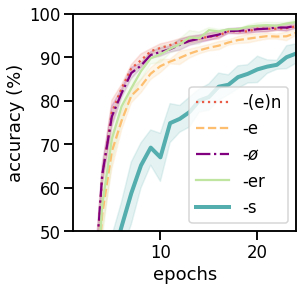

In [38]:
sns.set_context("talk")
plt.figure(figsize=(4, 4))
colours = sns.color_palette("Spectral", 5)
colours[2] = "purple"
epochs = list(range(1, 25))
linestyles = [':', '--', '-.', '-', '-',  '-', '-', '-']
labels = {0: "-(e)n", 1: "-e", 2: r"-$\o$", 3: "-er", 4: "-s", 7: "-s, vowel"}

for i in [0, 1, 2, 3]:
    mean = np.mean([[y * 100 for y in x[i]] for x in over_seeds], axis=0)
    std = np.std([[y * 100 for y in x[i]] for x in over_seeds], axis=0)
    sns.lineplot(x=epochs, y=mean, color=colours[i], linestyle=linestyles[i], label=labels[i])
    plt.fill_between(epochs, mean - std, mean + std, color=colours[i], alpha=0.15)

i = 4
mean = np.mean([[y * 100 for y in x[i]] for x in over_seeds], axis=0)
std = np.std([[y * 100 for y in x[i]] for x in over_seeds], axis=0)
sns.lineplot(x=epochs, y=mean, color=colours[i], linestyle='-', linewidth=4, label="-s")
plt.fill_between(epochs, mean - std, mean + std, color=colours[i], alpha=0.15)

plt.ylim(50, 100)
plt.xlim(1, 24)
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend()
plt.savefig("figures/training_accuracy.pdf", bbox_inches="tight")

#### Step 4: separately visualise the vowels and consonants for -s.

Loading data for model with seed 1.
Loading data for model with seed 2.
Loading data for model with seed 3.
Loading data for model with seed 4.
Loading data for model with seed 5.


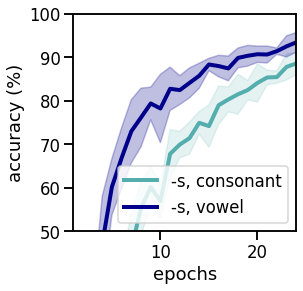

In [39]:
over_seeds = []
for i in range(1, 6):
    over_seeds.append(load_train(i, s_subset))

sns.set_context("talk")
plt.figure(figsize=(4, 4))
colours = sns.color_palette("Spectral", 5)

i = 4
mean = np.mean([[y * 100 for y in x[i]] for x in over_seeds], axis=0)
std = np.std([[y * 100 for y in x[i]] for x in over_seeds], axis=0)
sns.lineplot(x=epochs, y=mean, color=colours[i], linestyle='-', linewidth=4, label="-s, consonant")
plt.fill_between(epochs, mean - std, mean + std, color=colours[i], alpha=0.15)

i = 7
mean = np.mean([[y * 100 for y in x[i]] for x in over_seeds], axis=0)
std = np.std([[y * 100 for y in x[i]] for x in over_seeds], axis=0)
sns.lineplot(x=epochs, y=mean, color="darkblue", linestyle='-', linewidth=4, label="-s, vowel")
plt.fill_between(epochs, mean - std, mean + std, color="darkblue", alpha=0.25)

plt.ylim(50, 100)
plt.xlim(1, 24)
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend()
plt.savefig("figures/vowel_consonant_curve.pdf", bbox_inches="tight")